## Resources

* [David Robinson's analysis](https://github.com/dgrtwo/data-screencasts/blob/master/space-launches.Rmd)

In [1]:
import pandas as pd
import numpy as np
import requests

from plotnine import *
from siuba import *
from siuba.dply.vector import n
from siuba.dply.forcats import fct_collapse, fct_lump, fct_reorder

from qgrid import show_grid

Description
----------------
* launch data over time
* shift from private to commercial
* highlighting some disasters

In [2]:
agencies = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-01-15/agencies.csv")
launches = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-01-15/launches.csv")


launches["launch_date_dt"] = pd.to_datetime(launches.launch_date, errors = 'coerce')

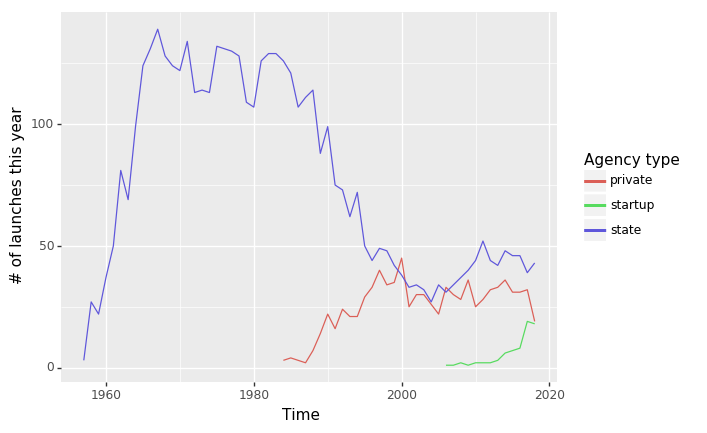

<ggplot: (-9223372036559351822)>

In [3]:
(launches
  >> count(_.launch_year, _.agency_type)
  >> ggplot(aes("launch_year", "n", color = "agency_type"))
   + geom_line()
   + labs(x = "Time", y = "# of launches this year", color = "Agency type")
  )

In [4]:
from datetime import datetime
datetime.now()

datetime.datetime(2019, 5, 3, 18, 28, 22, 105595)

In [5]:
launches >> count(_.agency_type, _.agency, sort = True)

agencies >> count(_.state_code, wt = _.count, sort = True)

launches_processed = (launches
  >> filter(_.launch_date_dt <= datetime.now())
  >> mutate(state_code = fct_collapse(
       _.state_code,
       {"RU": ["SU", "RU"], "FR": "F", "JP": "J", "IT": "I"}
     ))
   >> mutate(state_name = fct_lump(_.state_code, 6).fillna('Other'))
  )


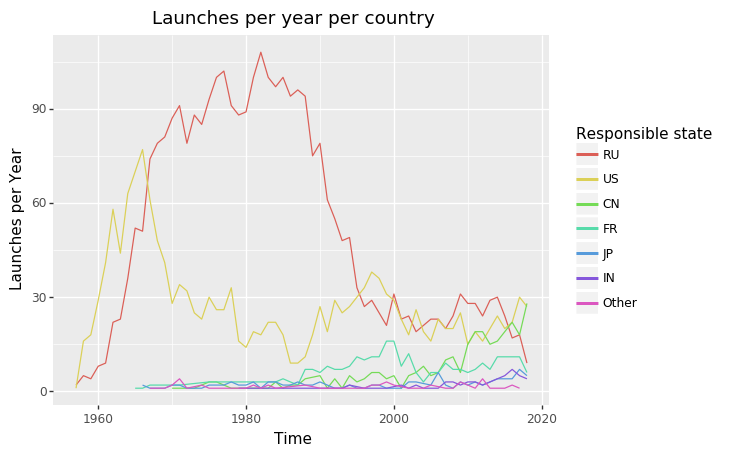

<ggplot: (-9223372036559976595)>

In [6]:
(launches_processed
  >> count("launch_year", "state_name")
  >> mutate(state_name = fct_reorder(_.state_name, -_.n, np.sum))
  >> ggplot(aes("launch_year", "n", color = "state_name"))
   + geom_line()
   + labs(x = "Time", y = "Launches per Year", color = "Responsible state",
          title = "Launches per year per country",
          subtitle = "Combines Soviet Union (pre-1990) with Russia")
  )

## Focus on private + startup launches

In [7]:
agencies >> filter(_, _.agency_type.isin(["private", "startup"]))

# Note: fct_lump currently doesn't keep all tied levels
private_startup_launches = (launches_processed
  >> filter(_, _.agency_type.isin(['private', 'startup']))
  >> inner_join(_,
       agencies >> select(_, "agency", _.agency_name == "name", "short_name", "parent"),
       "agency"
       )
  # note unlike R, mutate can't take same named arg twice in python
  >> mutate(_, agency_name_lumped = fct_lump(_.agency_name, 6))
  >> mutate(_,
      agency_name_lumped = if_else(
         (_.agency_name_lumped == "Other") & (_.state_name == "US"),
         "Other US",
         _.agency_name_lumped
         )
       )
  )

private_startup_launches.head()

,tag,JD,launch_date,launch_year,type,variant,mission,agency,state_code,category,agency_type,launch_date_dt,state_name,agency_name,short_name,parent,agency_name_lumped
0,1984-114,2446014.55,1984-11-10,1984,Ariane 3,NaN,Spacenet F2,AE,FR,O,private,1984-11-10,FR,"Arianespace, Inc.",Arianespace,-,"Arianespace, Inc."
1,1984-049,2445843.56,1984-05-23,1984,Ariane 1,NaN,Spacenet F1,AE,FR,O,private,1984-05-23,FR,"Arianespace, Inc.",Arianespace,-,"Arianespace, Inc."
2,1984-081,2445917.06,1984-08-04,1984,Ariane 3,NaN,ECS 2,AE,FR,O,private,1984-08-04,FR,"Arianespace, Inc.",Arianespace,-,"Arianespace, Inc."
3,1985-015,2446105.47,1985-02-08,1985,Ariane 3,NaN,Arabsat 1A,AE,FR,O,private,1985-02-08,FR,"Arianespace, Inc.",Arianespace,-,"Arianespace, Inc."
4,1985-035,2446193.55,1985-05-08,1985,Ariane 3,NaN,Gstar 1A,AE,FR,O,private,1985-05-08,FR,"Arianespace, Inc.",Arianespace,-,"Arianespace, Inc."


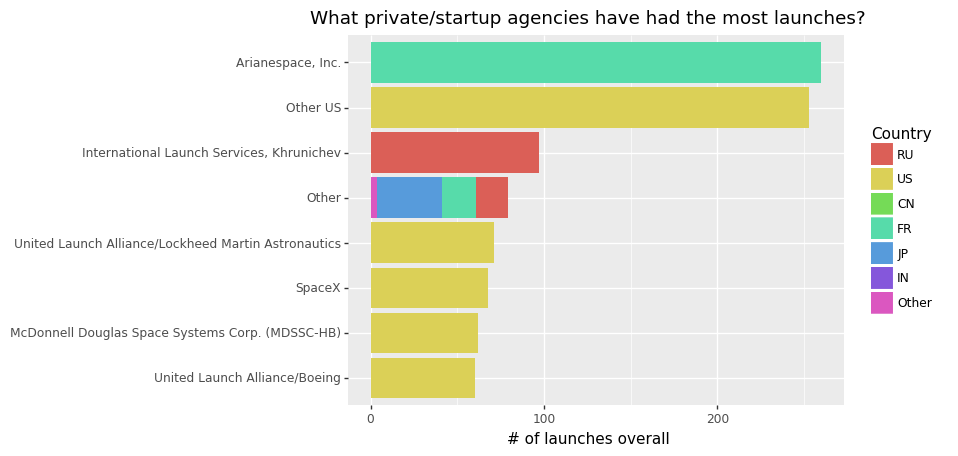

<ggplot: (-9223372036559779303)>

In [8]:
(private_startup_launches
  >> count(_, _.agency_name_lumped, _.state_name, sort = True)
  >> mutate(_, agency_name_lumped = fct_reorder(_.agency_name_lumped, _.n, np.sum))
  >> ggplot(aes("agency_name_lumped", "n", fill = "state_name"))
   + geom_col()
   + coord_flip()
   + labs(x = "", y = "# of launches overall",
          title = "What private/startup agencies have had the most launches?",
          fill = "Country"
         )
  )

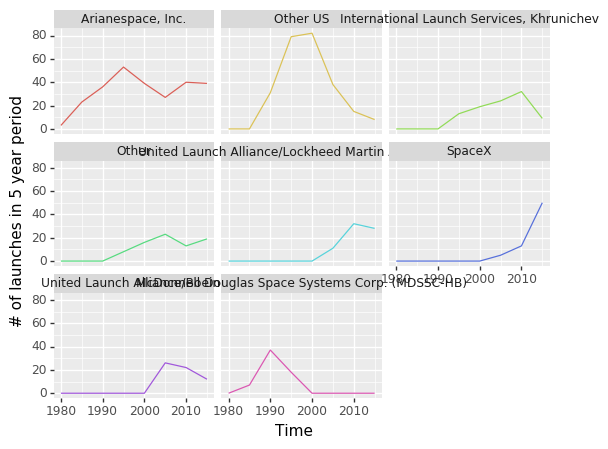

<ggplot: (295134717)>

In [9]:
(private_startup_launches
  >> count(
       _.agency_name_lumped,
       decade = 5 * (_.launch_year // 5)
     )
  >> complete(_.agency_name_lumped, _.decade, fill = {'n': 0})
  >> mutate(agency_name_lumped = fct_reorder(_.agency_name_lumped, -_.n, np.sum))
  >> ggplot(aes("decade", "n", color = "agency_name_lumped"))
   + geom_line()
   + facet_wrap("~ agency_name_lumped")
   + theme(legend_position = "none")
   + labs(x = "Time",
          y = "# of launches in 5 year period")
  )

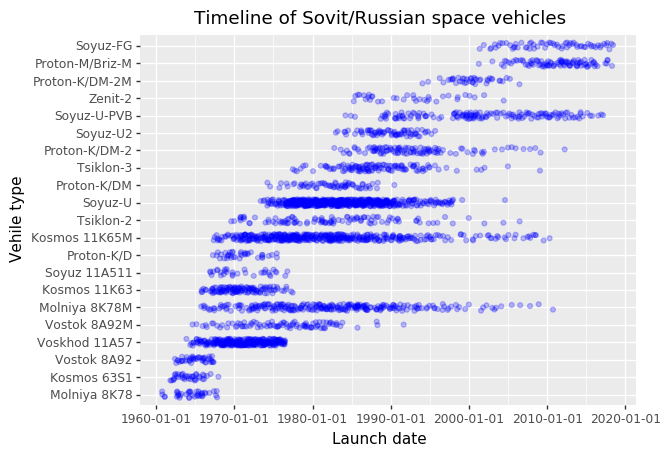

<ggplot: (297778552)>

In [10]:
# TODO: semi_join
vehicles = (launches_processed
  >> group_by(_.type, _.state_name)
  >> summarize(
       first_launch = _.launch_year.min(),
       last_launch = _.launch_year.max(),
       launches = n(_)
     )
  >> ungroup()
  )

russian_vehicles = (vehicles
  >> filter(_.state_name == "RU")
  >> arrange(-_.launches)
  >> filter(_.launches >= 30)
  )


# Note: use lambda in mutate since it's about as convenient
# as a symbolic expression
(launches_processed
  >> semi_join(_, russian_vehicles, on = "type")
  >> mutate(
       type = fct_reorder(_.type, _.launch_date, np.min),
       launch_date = lambda _: pd.to_datetime(_.launch_date)
     )
  >> ggplot(aes("launch_date", "type", color = "agency_type"))
   + geom_jitter(color = "blue", alpha = .25, width = 0, height = .2)
   + scale_y_discrete() 
   + theme(legend_position = "none")
   + labs(title = "Timeline of Sovit/Russian space vehicles",
          x = "Launch date",
          y = "Vehile type",
          subtitle = "Only vehicles with at least 30 launches"
         )
  )

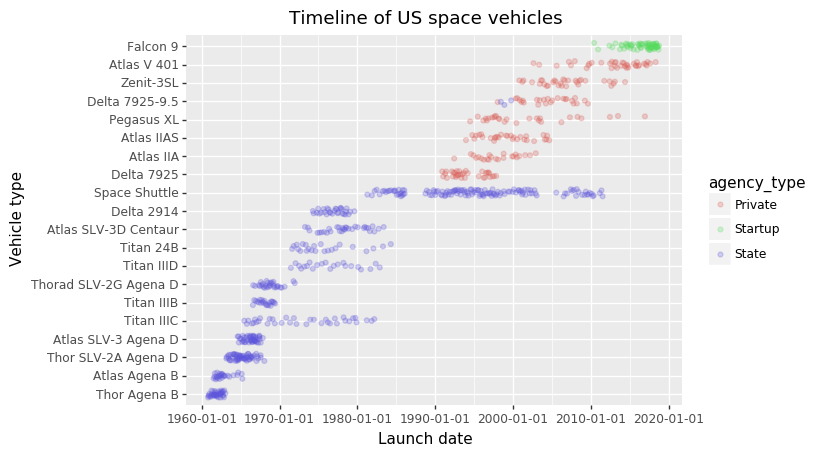

<ggplot: (297752335)>

In [11]:
(launches_processed
  >> filter(_.state_code == "US")
  >> add_count(_.type)
  >> filter(_.n >= 20)
  >> mutate(
    type = fct_reorder(_.type, _.launch_date, np.min),
    agency_type = _.agency_type.str.capitalize(),
    launch_date = lambda _: pd.to_datetime(_.launch_date)
    )
  >> ggplot(aes("launch_date", "type", color = "agency_type"))
   + geom_jitter(alpha = .25, width = 0, height = .2)
   + labs(title = "Timeline of US space vehicles",
          x = "Launch date", y = "Vehicle type", coor = "Agency type",
          subtitle = "Only vehicles with at least 20 launches"
          )
  )

# Misc

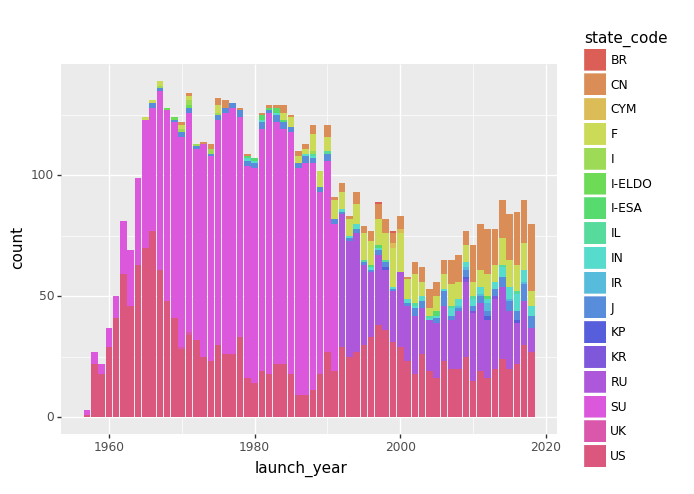

<ggplot: (-9223372036559976637)>

In [12]:
#pd.to_datetime(launches.launch_date)
#launches >> filter("launch_date")
(launches
  >> count("state_code", sort = True)
  >> mutate(
       state_label = if_else(_.n > 100, _.state_code, 'other')      
       )
  >> right_join(_, launches, on = "state_code")
  >> ggplot(aes("launch_year", fill = "state_code"))
   + geom_bar()
  )
